In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Telemetry

In [2]:
tele_file = pd.read_feather("../resources/kernel_metadata/shared_telemetry_info.csv")
#list_width = tele_file["width"].tolist()
#list_layers = tele_file["layers"].tolist()
#list_shots = tele_file["shots"].tolist()
#list_program_id = tele_file["program"].tolist()
#list_circuit_id = tele_file["circuit_id"].tolist()
#list_job_id = tele_file["job_id"].tolist()
#list_time_queue = tele_file["time_queue"].tolist()
#list_time_simu = tele_file["time_simu"].tolist()
#list_payload_size = tele_file["payload_size"].tolist()
#list_nb_circuits = tele_file["nb_circuits"].tolist()
#list_comment = tele_file["comment"].tolist()

### Payload vs number of qubits
Look at (payload size / number of circuits) -- that is, the payload size per circuit -- versus number of qubits, where the number of layers is fixed to be 1. This tells us something about the data costs associated with generating 1 circuit for a fixed number of qubits.

#### Info about the size
Good to know to study the following graphs :
- At the creation of any circuit a minimal size is required to init the circuit with all the parameters and so if we generated 3 circuits with a very little template and 100 with a big template. At the end, 1 big circuit will be less than 1 little circuit by % of all the circuits of its category.  
We could say 1 circuit with 4 qubit and 1 layer has a size of ~8ko.

#### Only 1 layer

Size of dataframe :  20


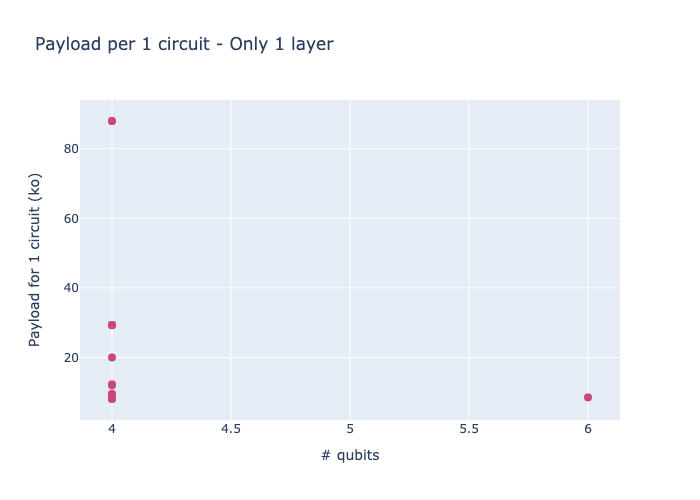

In [3]:
only1layer = tele_file.loc[tele_file['layers'] == 1]
olayer_layers = only1layer["layers"].tolist()
olayer_width = only1layer["width"].tolist()
olayer_payload_size = only1layer["payload_size"].tolist()
olayer_nb_circuits = only1layer["nb_circuits"].tolist()

olayer_payload_per_circuit = []
for payload_size, nb_circuits in zip(olayer_payload_size, olayer_nb_circuits):
    olayer_payload_per_circuit.append(float(payload_size/nb_circuits))
    
print("Size of dataframe : ", len(olayer_payload_per_circuit))

fig = go.Figure([go.Scatter(x=olayer_width, y=olayer_payload_per_circuit, mode='markers',
                                   marker=dict(color=olayer_layers, size=8))])

fig.update_layout(title_text='Payload per 1 circuit - Only 1 layer',
                         xaxis_title="# qubits", yaxis_title="Payload for 1 circuit (ko)")

fig.show("png")

#### All layers

Size of dataframe :  32


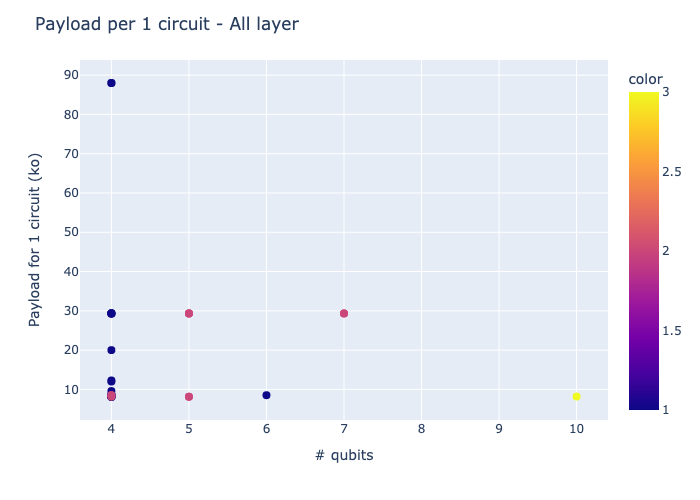

In [4]:
list_layers = tele_file["layers"].tolist()
list_width = tele_file["width"].tolist()
list_payload_size = tele_file["payload_size"].tolist()
list_nb_circuits = tele_file["nb_circuits"].tolist()

payload_per_circuit = []
for payload_size, nb_circuits in zip(list_payload_size, list_nb_circuits):
    payload_per_circuit.append(float(payload_size/nb_circuits))
    
print("Size of dataframe : ", len(payload_per_circuit))


fig = px.scatter(x=list_width, y=payload_per_circuit, color=list_layers)

fig.update_traces(marker=dict(size=8))

fig.update_layout(title_text='Payload per 1 circuit - All layer',
                         xaxis_title="# qubits", yaxis_title="Payload for 1 circuit (ko)")

fig.show("png")

### Payload vs number of circuits
Look at payload size versus number of circuits. This tells us how payload size scales with the number of kernel values we're trying to calculate in 1 go.

Size of dataframe :  32


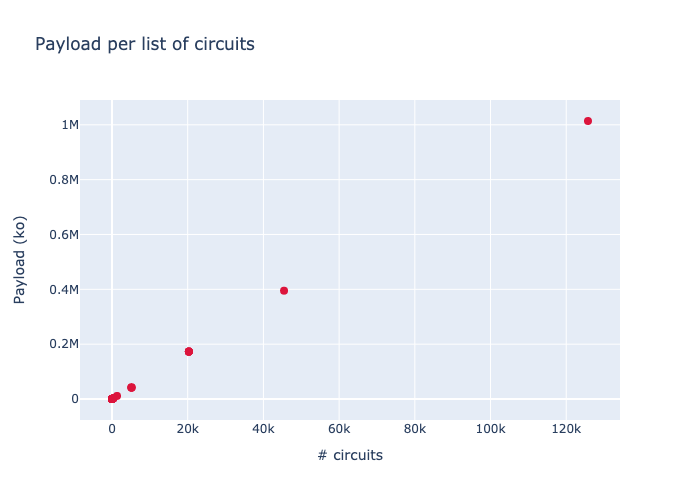

In [5]:
list_payload_size = tele_file["payload_size"].tolist()
list_nb_circuits = tele_file["nb_circuits"].tolist()
    
print("Size of dataframe : ", len(list_payload_size))

fig = go.Figure([go.Scatter(x=list_nb_circuits, y=list_payload_size, mode='markers',
                            marker=dict(color="crimson", size=8))])

fig.update_layout(title_text='Payload per list of circuits', 
                         xaxis_title="# circuits", yaxis_title="Payload (ko)")

fig.show("png")

#### Histogram
Histogram of payload size/number of circuits. Does there are any interesting features in the distribution ?

Size of dataframe :  32


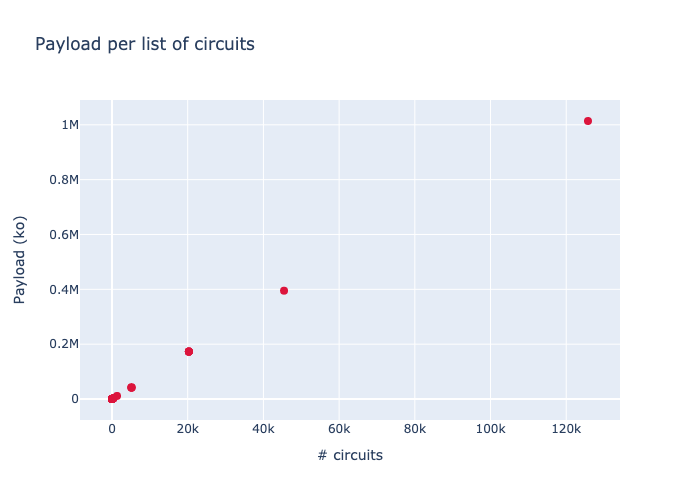

In [6]:
list_payload_size = tele_file["payload_size"].tolist()
list_nb_circuits = tele_file["nb_circuits"].tolist()

payload_size_percent = []
nb_circuits_percent = []

for payload_size, nb_circuits in zip(list_payload_size, list_nb_circuits):
    payload_size_percent.append(payload_size * 100 / sum(list_payload_size))
    nb_circuits_percent.append(nb_circuits * 100 / sum(list_nb_circuits))

print("Size of dataframe : ", len(payload_size_percent))

fig_series = make_subplots(rows=2, cols=2, subplot_titles=("Percent", "Real value", "Percent", "Real value"))

fig_series.add_trace(go.Histogram(x=payload_size_percent, name='Payload %'), row=1, col=1)
fig_series.add_trace(go.Histogram(x=list_payload_size, name='Payload R'), row=1, col=2)
fig_series.update_xaxes(title_text="payload size", row=1)

fig_series.add_trace(go.Histogram(x=nb_circuits_percent, name='# circuits %'), row=2, col=1)
fig_series.add_trace(go.Histogram(x=list_nb_circuits, name='# circuits R'), row=2, col=2)
fig_series.update_xaxes(title_text="# circuits", row=2)

fig_series.update_layout(
    title_text='Payload & # circuits',
    yaxis_title="Count",
    barmode="overlay")
fig_series.update_xaxes(title_text="# circuits", row=2)

fig_series.update_traces(opacity=0.7)

fig.show("png")

### Runtime seconds vs number of circuits
Time_simulation (aka, runtime-seconds) versus payload size. This helps us see what the cutoffs look like. For this plot, I would suggest plotting lines indicating the payload size at which the Runtime says it was too big, as well as the time past which the Runtime said it timed out.

Size of dataframe :  32


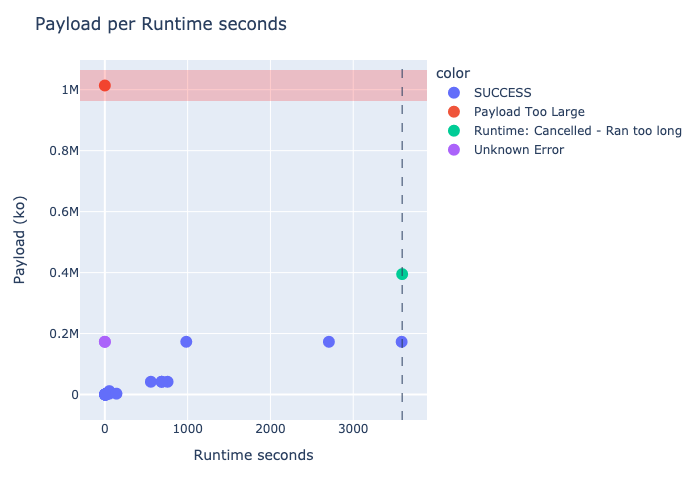

In [7]:
list_payload_size = tele_file["payload_size"].tolist()
list_time_simu = tele_file["time_simu"].tolist()
list_comment = tele_file["comment"].tolist()

exceed_payload = []
exceed_time = []
for time_simu, payload_size, comment in zip(list_time_simu, list_payload_size, list_comment):
    exceed_payload.append(payload_size) if comment == "Payload Too Large" else None
    exceed_time.append(time_simu) if comment == "Runtime: Cancelled - Ran too long" else None
    
print("Size of dataframe : ", len(list_payload_size))

fig = px.scatter(x=list_time_simu, y=list_payload_size, color=list_comment)
fig.add_hrect(y0=(min(exceed_payload)-min(exceed_payload)/20), y1=(max(exceed_payload)+max(exceed_payload)/20), 
              line_width=0,line_color="red", fillcolor="red", opacity=0.2)
fig.add_vline(x=min(exceed_time), fillcolor="green", line_width=1, line_dash="dash")

fig.update_traces(marker=dict(size=12))
fig.update_layout(title_text='Payload per Runtime seconds', 
                  xaxis_title="Runtime seconds", yaxis_title="Payload (ko)")

fig.show("png")

In [18]:
#tele_file